In [1]:
from framework import *
import nevis
from scipy.optimize import dual_annealing
import numpy as np
import matplotlib.pyplot as plt


f = nevis.linear_interpolant()
x_max, y_max = nevis.dimensions()

In [2]:
def run_dual_annealing(**kwargs):
    points = []
    function_values = []
    def wrapper(u):
        x, y = u
        points.append((x, y))
        z = f(x, y)
        function_values.append(z)
        return -z

    x_max, y_max = nevis.dimensions()
    ret = dual_annealing(
        wrapper, 
        bounds=[(0, x_max), (0, y_max)],
        maxfun=MAX_FES,
        **kwargs
    )

    return Result(
        ret.x,
        -ret.fun,
        points,
        ret.message,
        function_values,
        ret_obj=ret
    )

algo = Algorithm(
    'Dual Annealing', 
    run_dual_annealing,
    {
        # 'maxiter': np.arange(1500, 3000, 100),
        'maxiter': [2000],
        'initial_temp': np.linspace(2e4, 4e4, 1000),
        'restart_temp_ratio': np.logspace(-5, -3, 100),
        # 'visit': np.linspace(1 + EPS, 3, 1000),
        # 'accept': np.logspace(-5, -1e-4, 1000),
    },
    version=3
)
algo.tune_params(
    measure='ert',
    mode='min'
)

# algo.plot_instances(
#     x_measure='success_rate',
#     y_measure='avg_height'
# )
# plt.show()


Calculating instance 1 / 50
ert = 704977.0

Calculating instance 2 / 50
ert = 703025.0

Calculating instance 3 / 50
ert = inf

Calculating instance 4 / 50
ert = 723286.0

Calculating instance 5 / 50
ert = 329523.0

Calculating instance 6 / 50
ert = inf

Calculating instance 7 / 50
ert = 328558.5

Calculating instance 8 / 50
ert = 330645.5

Calculating instance 9 / 50
ert = 331008.5

Calculating instance 10 / 50
ert = 702041.0

Calculating instance 11 / 50
ert = 708939.0

Calculating instance 12 / 50
ert = 704865.0

Calculating instance 13 / 50
ert = 328521.0

Calculating instance 14 / 50
ert = 328016.0

Calculating instance 15 / 50
ert = 330554.0

Calculating instance 16 / 50
ert = inf

Calculating instance 17 / 50
ert = 705503.0

Calculating instance 18 / 50
ert = 204470.0

Calculating instance 19 / 50
ert = 705114.0

Calculating instance 20 / 50
ert = 203821.66666666666

Calculating instance 21 / 50
ert = 704831.0

Calculating instance 22 / 50
ert = 705380.0

Calculating instance 23 

In [3]:
algo_instance = algo.best_instance
print(algo_instance.success_measures())
algo_instance.print()


{'success_rate': 0.3333333333333333, 'failure_rate': 0.6666666666666667, 'success_cnt': 5, 'avg_success_eval': 5808.6, 'hv': 14730.466666666667, 'performance': 17425.8, 'par2': 68602.86666666667, 'par10': 335269.5333333333, 'avg_height': 1295.96685029713, 'ert': 105808.60000000003}
{'algorithm_name': 'Dual Annealing',
 'algorithm_version': 3,
 'initial_temp': 38678.67867867868,
 'maxiter': 2000,
 'restart_temp_ratio': 0.0001176811952434999}
=== Result #0 ===
10654
Congratulations!
You landed at an altitude of 1309m.
  https://opentopomap.org/#marker=15/57.070204/-3.669488
You are 31m from the nearest named hill top, "Ben Macdui",
  ranked the 2d heighest in GB.
  http://hillsummits.org.uk/htm_summit/518.htm

=== Result #1 ===
9469
Congratulations!
You landed at an altitude of 1232m.
  https://opentopomap.org/#marker=15/56.799757/-4.954647
You are 43m from the nearest named hill top, "Aonach Beag",
  ranked the 11th heighest in GB.
  http://hillsummits.org.uk/htm_summit/279.htm

=== Res

Length of function_values: 15
Length of distance_values: 15


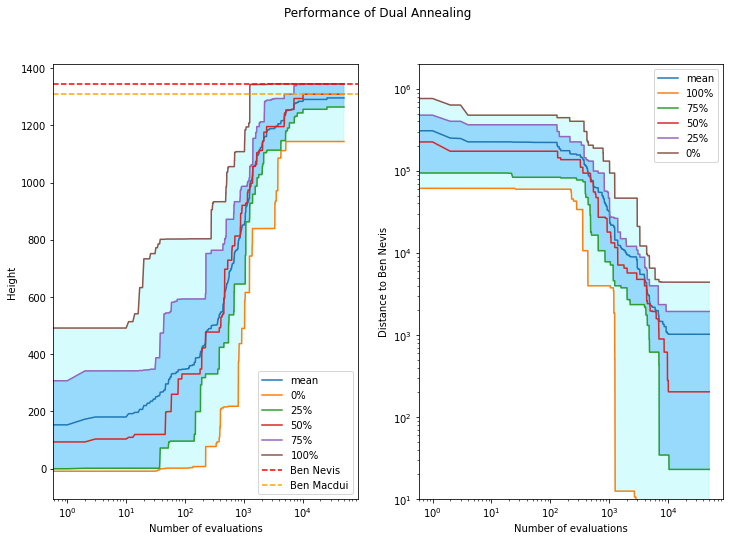

In [4]:
algo_instance.plot_convergence_graph()
plt.show()

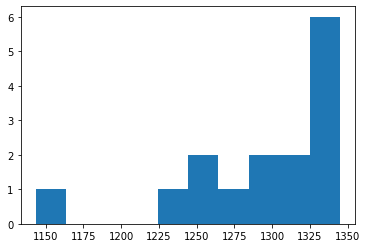

In [5]:
algo_instance.plot_histogram()

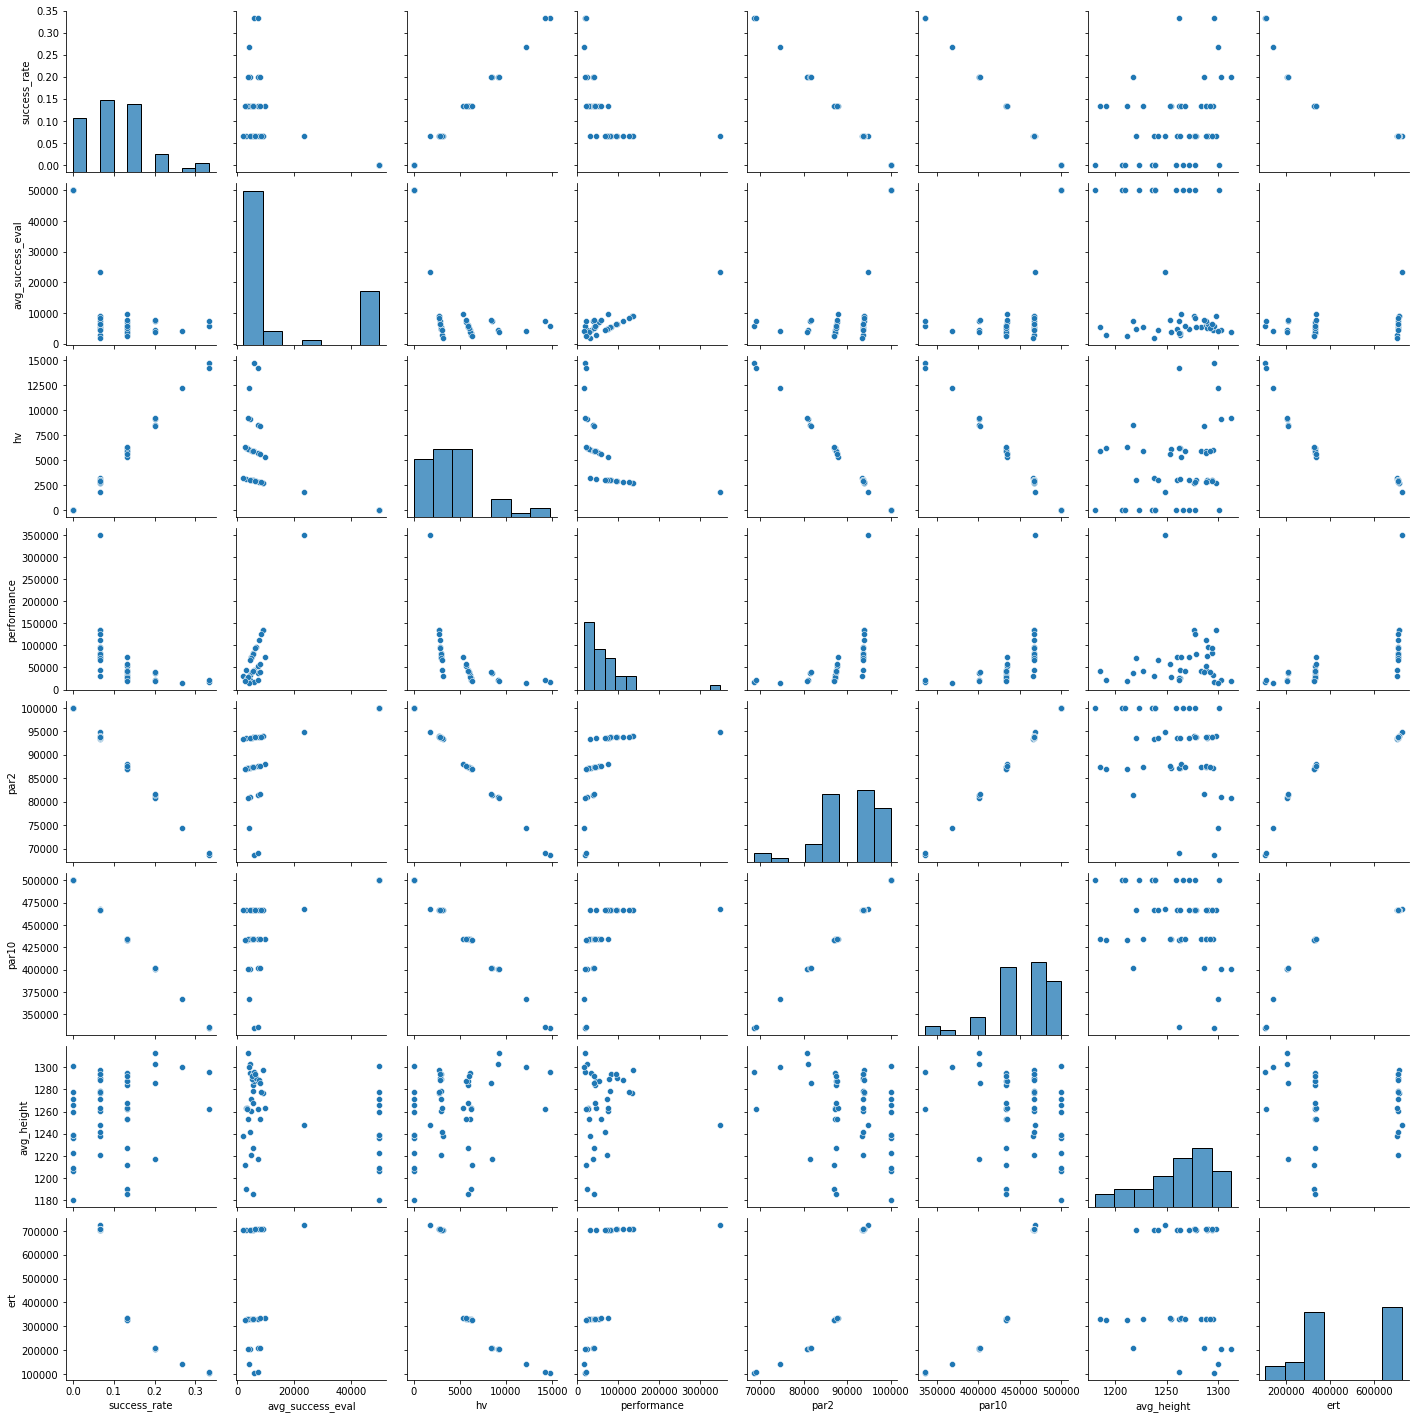

In [5]:
algo.plot_all()

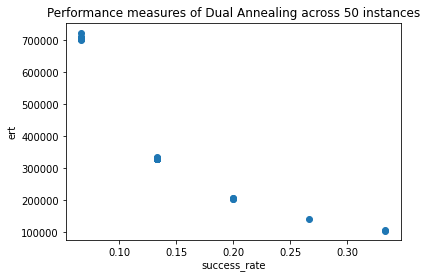

In [6]:
algo.plot_instances('success_rate', 'ert')

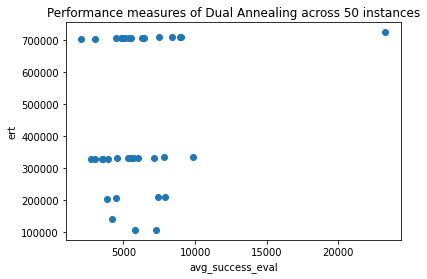

In [7]:
algo.plot_instances('avg_success_eval', 'ert')


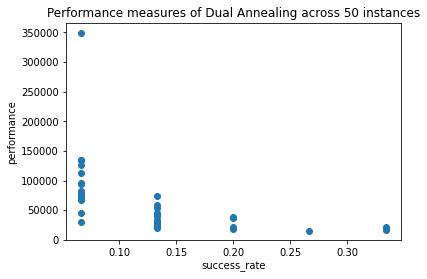

In [8]:
algo.plot_instances('success_rate', 'performance')

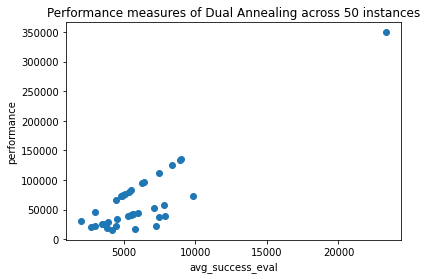

In [9]:
algo.plot_instances('avg_success_eval', 'performance')

Running instance 1
{'algorithm_name': 'CMAES', 'algorithm_version': 2}


100%|██████████| 15/15 [01:56<00:00,  7.75s/it]


Length of function_values: 15
Length of distance_values: 15


(<Figure size 720x720 with 2 Axes>,
 (<AxesSubplot:xlabel='Number of evaluations', ylabel='Height'>,
  <AxesSubplot:xlabel='Number of evaluations', ylabel='Distance to Ben Nevis'>))

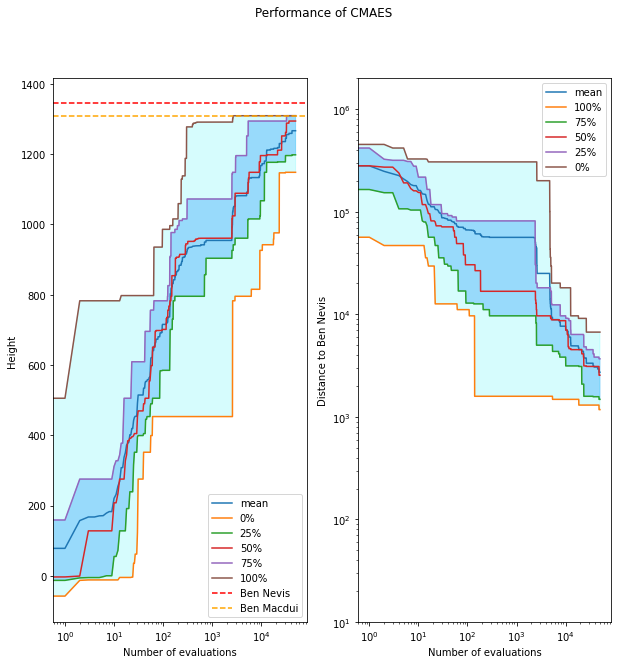

In [2]:
import pints


def run_cmaes(population_size=None):
    # Visited points, and means per iteration
    points = []
    heights = []

    # Use best found, instead of best guessed
    use_x_best = False


    # Create pints error measure
    class Error(pints.ErrorMeasure):
        """
        Turn a height into an error to be minimised.

        Writes to global var: not suitable for parallelistion!
        """
        def __init__(self, spline):
            self.f = spline

        def n_parameters(self):
            return 2

        def __call__(self, p):
            points.append(p)
            z = self.f(*p)
            heights.append(z)
            return -z
    b = pints.RectangularBoundaries([0, 0], [x_max, y_max])

    fes = MAX_FES

    e = Error(f)

    x_best, f_best = None, 0

    while fes > 0:

        x0 = b.sample()
        s0 = min(b.range()) / 2
        opt = pints.OptimisationController(
            e,
            x0=x0,
            sigma0=s0,
            boundaries=b,
            method=pints.CMAES
        )
        if population_size is not None:
            opt.optimiser().set_population_size(population_size)
        # opt.set_max_unchanged_iterations(100, threshold=0.01)
        opt.set_max_evaluations(fes)
        opt.set_threshold(-SUCCESS_HEIGHT)
        opt.set_f_guessed_tracking(not use_x_best)
        opt.set_log_to_screen(False)
        x1, f1 = opt.run()

        if -f1 > f_best:
            x_best, f_best = x1, f1

        fes -= opt.evaluations()

    return Result(
        x1, 
        -f1, 
        points, 
        heights=heights
    )


algo_cmaes = Algorithm(
    'CMAES',
    run_cmaes,
    {},
    2
)

instance = algo_cmaes.generate_instance(instance_hash=1)
instance.run(15)
instance.plot_convergence_graph()
plt.show()


In [20]:
res = run_cmaes(20)
res.print()

Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 20
Iter. Eval.  Best      Current   Time m:s
0     20     -423.0156 -423.0156   0:00.0
1     40     -438.9105 -438.9105   0:00.0
2     60     -461.1278 -461.1278   0:00.0
3     80     -461.1278 -457.2451   0:00.0
20    420    -869.839  -607.1081   0:00.0
40    820    -870.6841 -781.9108   0:00.1
60    1220   -870.6841 -847.1098   0:00.1
80    1620   -870.6841 -847.7954   0:00.1
100   2020   -870.6841 -847.8      0:00.1
120   2420   -870.6841 -847.8      0:00.2
140   2820   -870.6841 -847.8      0:00.2
160   3220   -870.6841 -847.8      0:00.2
180   3620   -870.6841 -847.8      0:00.3
200   4020   -870.6841 -847.8      0:00.3
220   4420   -870.6841 -847.8      0:00.3
240   4820   -870.6841 -847.8      0:00.4
260   5220   -870.6841 -847.8      0:00.4
280   5620   -870.6841 -847.8      0:00.4
300   6020   -870.6841 -847.8      0:00.4
320   6420   -870.6841 -